In [1]:
import urllib2  
from bs4 import BeautifulSoup
import sys
import time
from datetime import datetime
from nltk.corpus import stopwords
import string
import re
import pickle
import pandas as pd
import numpy as np
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
import matplotlib.pyplot as plt
from scipy.interpolate import spline

%matplotlib inline

            

In [86]:
def get_headlines(quote_page):
    user_specs = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'
    user_specs2 = '"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; Googlebot/2.1; +http://www.google.com/bot.html) Safari/537.36", "browser": { "name": "Safari" }, "engine": { "version": "537.36", "name": "WebKit" }, "os": {}, "device": {}, "cpu": {}'
    #quote_page = 'https://www.google.com/search?q=ebola&source=lnt&tbs=cdr%3A1%2Ccd_min%3A1%2F1%2F2015%2Ccd_max%3A3%2F31%2F2015&tbm=nws#q=ebola&tbs=cdr:1,cd_min:1/1/2015,cd_max:3/31/2015&tbm=nws&start=' + str(index)
  
    req = urllib2.Request(quote_page)
    req.add_header('User-Agent', user_specs)
    response = urllib2.urlopen(req)
    
    soup = BeautifulSoup(response, 'html.parser')  
    gs = soup.find_all(attrs={'class': 'g'})

    store = []
    for g in gs:
        print "\n"
        for i in g.stripped_strings:
            clean = i.encode('utf-8')
            store.append(clean)
            print clean
            
    return store


def create_url(query, month, day, year):
    url = 'https://www.google.com/search?q=' + str(query) + '&biw=1256&bih=699&source=lnt&tbs=cdr%3A1%2Ccd_min%3A' + str(month) + '%2F' + str(day) + '%2F' + str(year) + '%2Ccd_max%3A' + str(month) + '%2F' + str(day) + '%2F' + str(year) + '&tbm=nws'
    return url


def get_data(query):
    
    store = []
    for i in xrange(29,32):
        url = create_url(query, 7, i, 2014)
        store.append(url)
    for i in xrange(1,19):
        url = create_url(query, 8, i, 2014)
        store.append(url)
    
    headlines = []
    for i in store:
        one_day = get_headlines(i)
        headlines.append(one_day)
        time.sleep(np.random.randint(10,20))
        
    return headlines

In [ ]:
results = get_data('ebola')

Sample result:

Where Does
Ebola
Come From?
The Atlantic
-
Jul 29, 2014
The worst
Ebola
virus outbreak ever is ravaging Liberia, Sierra Leone, and Guinea. So far, the disease has killed 670 people and infected more than 1,000, ...
Why Deadly
Ebola
Virus Is Likely to Hit the US But Not Spread
National Geographic
-
Jul 29, 2014
Ebola
outbreak: Asky bans flights in West Africa
BBC News
-
Jul 29, 2014
Public health adviser Yewande Adeshina said 30000 people at risk ...
In-Depth
-
Daily Mail
-
Jul 29, 2014
Ebola
Politics
Blog
-
Slate Magazine (blog)
-
Jul 29, 2014
Ebola
plane travel scare has officials on edge
In-Depth
-
CBS News
-
Jul 29, 2014
National Geographic
Slate Magazine (blog)
BBC News
Telegraph.co.uk
Daily Mail
Forbes
View all


Azaria Marthyman,
Ebola
doctor, returns home to Victoria
CBC.ca
-
Jul 29, 2014
Dr. Azaria Marthyman, a Victoria doctor who was part of a medical group that travelled to Liberia earlier this month to treat victims of the
Ebola
virus has returned ...
Victoria doctor places himself in quarantine after treating
Ebola
in ...
International
-
Globalnews.ca
-
Jul 29, 2014

In [140]:
def cleanup(data):
    joined = ','.join(data)
    clean_view = joined.replace("View all", "")
    spaced = clean_view.replace(",", " ")
    splitlis = re.split(r'\s\s(201\d{1})', spaced)
    articles = [ x + " " + y for x,y in zip(splitlis[0::2], splitlis[1::2]) ]
    return articles

def clean_and_flatten(data):
    cleaned_data = []
    for i in data:
        cleaned_data.append(cleanup(i))
    flat = [item for sublist in cleaned_data for item in sublist]
    return flat

clean_and_flatten(results)

In [ ]:
# save with pickle
with open('jul28aug18.pickle', 'wb') as handle:
    pickle.dump(flat_cleaned_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [413]:
with open('jul28aug18.pickle', 'rb') as handle:
  b = pickle.load(handle)

In [422]:
news_sources = ['Scientific American', 'The Independent', 'Wall Street Journal', 'Aljazeera.', 'Washington Times', 
                'The Guardian', 'NBC', 'news', 'NBCNews.com', 'News', 'National Geographic', 'Slate Magazine',  
                'Aljazeera.com', 'Al Jazeera', 'Daily Mail', 'CBS', 'Yahoo', 'USA TODAY','blog', 'Blog', 'NPR', 'BBC', 
                'Huffington Post', 'ABC', 'CNN', 'TIME', 'New York Times', 'Los Angeles Times', 'The Atlantic', 'Magazine', 
                'Washington Post', 'Mirror.co.uk', 'CBS News', 'CBC.ca', 'Fox', 'Telegraph.co.uk', 'Times', 'Reuters', 
                'Bloomberg', 'Toronto Star', 'The Streetjournal', 'New York Daily', 'U.S. News & World Report','Telegraph.co.uk', 
                'LiveScience.', 'International Business', 'Baltimore Sun', 'Mother Jones', 'SaharaReporters.com', 
                'The Globe and Mail', 'Daily Beast', 'Chicago Tribune', 'Christian Post', 'Business Insider', 'In-Depth','com']

def remove_news(line):
    for i in news_sources:
        line = line.replace(i, '')
    return line

no_news = map(remove_news, b)

In [423]:
def str_decode(string):
    return string.decode('utf-8')

def render_date(string):
    return datetime.strptime(string, '%b %d %Y')

def parse_and_split(data):
    df = pd.DataFrame(data, columns=['col'])
    df = df['col'].str.rsplit(' - ', 1, expand=True)
    df.columns = ['headline', 'date']
    df = df.dropna(0)
    df['headline'] = df['headline'].apply(str_decode)
    df['date'] = df['date'].apply(render_date)
    return df

df = parse_and_split(no_news)
    
print df['date'].value_counts()

2014-08-07    35
2014-08-05    34
2014-08-04    34
2014-08-08    34
2014-08-06    32
2014-08-12    29
2014-07-31    28
2014-08-13    27
2014-08-11    26
2014-08-01    26
2014-08-14    26
2014-08-10    26
2014-08-15    24
2014-08-03    23
2014-07-30    22
2014-08-16    21
2014-08-02    21
2014-08-09    18
2014-08-17    18
2014-07-29    17
2014-08-18    15
Name: date, dtype: int64


In [424]:
df.to_csv('raw_headlines.csv', sep=',', encoding='utf-8')

In [194]:
#tfidf clusters
def clusters_tfidf2(df, clusters_count = 7):
    vect = TfidfVectorizer(max_df = 0.1, max_features = None,
                                 stop_words = text.ENGLISH_STOP_WORDS.union(['ebola']),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(df['headline']) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count, random_state=3)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    store = []
    for i in range(clusters_count):
        cluster_num = "Cluster %d:" % (i + 1)
        topics = ', '.join([terms[ind] for ind in order_centroids[i, :8]])
        cluster_topics = cluster_num + ' ' + topics
        store.append(cluster_topics)
    return store

In [195]:
my_topics = clusters_tfidf2(df)
my_topics

[u'Cluster 1: opinion, report, world, know, crisis, deadly, border, emergency',
 u'Cluster 2: hospital, experimental, drug, nigeria, india, emergency, serum, vaccine',
 u'Cluster 3: leone, sierra, african, guinea, crisis, deadly, contain, nations',
 u'Cluster 4: drugs, experimental, ethics, ethical, use, says, patients, untested',
 u'Cluster 5: american, doctor, second, atlanta, arrives, kent, infected, brantly',
 u'Cluster 6: people, new, disease, quarantine, york, world, ward, inside',
 u'Cluster 7: spanish, priest, madrid, treated, infected, pajares, miguel, dies']

In [182]:
def create_lexicon(clusters):
    
    # create lexicon dictionary
    num_of_topics = len(clusters)
    df_ = pd.DataFrame(index=['df-init'], columns= [i+1 for i in range(num_of_topics)])

    for i in range(num_of_topics):
        cluster_i = (clusters[i])
        cluster_i = cluster_i.split(': ', 1)[1]
        cluster_i = cluster_i.split(',')
        df = pd.DataFrame(index=cluster_i, columns = [j+1 for j in range(num_of_topics)])
        for j in range(1+num_of_topics):
            if j == i:
                df[j+1] = 1
            else:
                df[j+1] = 0
        df_=df_.append(df)
    
    df_ = df_.drop(num_of_topics+1,1)
    df_ = df_.drop('df-init')
    
    return df_

In [196]:
def create_cluster_dict(clusters):
    
    # create cluster dictionary dataframe
    # intermediate object, discarded
    lex = pd.DataFrame(clusters, columns=['col'])
    lex = lex['col'].str.split(' ', 1, expand=True)
    lex = lex[1].str.rsplit(':', -1, expand=True)
    lex.columns = ['cluster', 'topics']
    
    # create cluster dictionary
    cluster_dict = lex.set_index('cluster').to_dict()
    cluster_dict = cluster_dict['topics']
    
    return cluster_dict

cluster_dict = create_cluster_dict(my_topics)

In [198]:
def my_tokenize(x):
        try:
            return word_tokenize(x)
        except UnicodeDecodeError:
            pass


def stopword_remove(x):
    stop_words = set(stopwords.words('english')).union(['ebola']) 
    list_of_words = [i.lower() for i in x if i.lower() not in stop_words]
    return list_of_words


def tokenize_and_stop(df):
    df['headline'] = df['headline'].apply(my_tokenize)
    df['headline'] = df['headline'].apply(stopword_remove)
    df['number of tokens'] = df['headline'].apply(len)
    return df


tokenize_and_stop(df)

,headline,date,number of tokens
0,"[come, ?]",2014-07-29,2
1,"[worst, virus, outbreak, ever, ravaging, liber...",2014-07-29,25
2,"[outbreak, :, asky, bans, flights, west, africa]",2014-07-29,7
3,"[public, health, adviser, yewande, adeshina, s...",2014-07-29,12
4,"[politics, -, (, )]",2014-07-29,4


In [382]:
df.to_csv('tokenized_headlines.csv', sep=',')

In [ ]:
# TODO: ngrams 
from nltk import ngrams
sentence = 'text text text text'
n = 2
sixgrams = ngrams(sentence.split(), n)
mystore = []
for grams in sixgrams:
    mystore.append(grams)
    print grams
    
# join tuple
joined = ','.join(asdf)
spaced = joined.replace(",", ' ')
spaced

In [199]:
def clustercount(df, cluster):
    col = []
    for line in df:
        count = 0
        for word in line:
            if word in cluster_dict[str(cluster)]:
                count = count + 1
        col.append(count)
    return col

# for each emotion, create a column with the number of words matching that emotion in a given tweet, then a ratio of the number of words
# matching that emotion against the total number of words in the tweet

def count_and_ratio(df):
    for i in xrange(1,len(my_topics)+1):
        df.loc[:, i] = clustercount(df['headline'], i)
        df.loc[:, str(i) + " hl ratio"] = df[i] / df['number of tokens']
    return df

count_and_ratio(df)

,headline,date,number of tokens,1,1 hl ratio,2,2 hl ratio,3,3 hl ratio,4,4 hl ratio,5,5 hl ratio,6,6 hl ratio,7,7 hl ratio
0,"[come, ?]",2014-07-29,2,0,0.00,0,0.0,0,0.000000,0,0.00,0,0.00,0,0.000000,0,0.00
1,"[worst, virus, outbreak, ever, ravaging, liber...",2014-07-29,25,1,0.04,0,0.0,4,0.160000,1,0.04,1,0.04,2,0.080000,1,0.04
2,"[outbreak, :, asky, bans, flights, west, africa]",2014-07-29,7,0,0.00,0,0.0,1,0.142857,0,0.00,0,0.00,0,0.000000,0,0.00
3,"[public, health, adviser, yewande, adeshina, s...",2014-07-29,12,0,0.00,0,0.0,0,0.000000,0,0.00,0,0.00,1,0.083333,0,0.00
4,"[politics, -, (, )]",2014-07-29,4,0,0.00,0,0.0,0,0.000000,0,0.00,0,0.00,0,0.000000,0,0.00


In [374]:
def group_date_and_ratio(df):
    grouped_by_date = df.groupby('date').sum()
    grouped_by_date
    for i in xrange(1,len(my_topics)+1):
        grouped_by_date.loc[:, str(i) + " date ratio"] = grouped_by_date[i] / grouped_by_date['number of tokens']
    return grouped_by_date
    
grouped_by_date = group_date_and_ratio(df)

,number of tokens,1,1 hl ratio,2,2 hl ratio,3,3 hl ratio,4,4 hl ratio,5,...,6 hl ratio,7,7 hl ratio,1 date ratio,2 date ratio,3 date ratio,4 date ratio,5 date ratio,6 date ratio,7 date ratio
date,,,,,,,,,,,,,,,,,,,,,
2014-07-29,282,5,0.207085,2,0.075736,17,0.907255,2,0.206667,6,...,0.372085,3,0.121940,0.017730,0.007092,0.060284,0.007092,0.021277,0.028369,0.010638
2014-07-30,363,15,1.055769,2,0.085455,15,0.766013,10,0.461119,13,...,0.271999,4,0.155499,0.041322,0.005510,0.041322,0.027548,0.035813,0.013774,0.011019
2014-07-31,411,16,1.131131,12,1.362637,21,1.311610,12,0.882400,12,...,0.082492,5,0.380909,0.038929,0.029197,0.051095,0.029197,0.029197,0.004866,0.012165
2014-08-01,352,9,0.722350,7,0.685775,14,1.121958,15,1.545092,6,...,0.284674,1,0.043478,0.025568,0.019886,0.039773,0.042614,0.017045,0.019886,0.002841
2014-08-02,291,9,1.144017,2,0.333333,16,1.412019,7,0.740397,27,...,0.342747,6,0.246812,0.030928,0.006873,0.054983,0.024055,0.092784,0.017182,0.020619


In [378]:
grouped_by_date.to_csv('ebola_data.csv', sep=',')

In [375]:
grouped_by_date

,number of tokens,1,1 hl ratio,2,2 hl ratio,3,3 hl ratio,4,4 hl ratio,5,...,6 hl ratio,7,7 hl ratio,1 date ratio,2 date ratio,3 date ratio,4 date ratio,5 date ratio,6 date ratio,7 date ratio
date,,,,,,,,,,,,,,,,,,,,,
2014-07-29,282,5,0.207085,2,0.075736,17,0.907255,2,0.206667,6,...,0.372085,3,0.121940,0.017730,0.007092,0.060284,0.007092,0.021277,0.028369,0.010638
2014-07-30,363,15,1.055769,2,0.085455,15,0.766013,10,0.461119,13,...,0.271999,4,0.155499,0.041322,0.005510,0.041322,0.027548,0.035813,0.013774,0.011019
2014-07-31,411,16,1.131131,12,1.362637,21,1.311610,12,0.882400,12,...,0.082492,5,0.380909,0.038929,0.029197,0.051095,0.029197,0.029197,0.004866,0.012165
2014-08-01,352,9,0.722350,7,0.685775,14,1.121958,15,1.545092,6,...,0.284674,1,0.043478,0.025568,0.019886,0.039773,0.042614,0.017045,0.019886,0.002841
2014-08-02,291,9,1.144017,2,0.333333,16,1.412019,7,0.740397,27,...,0.342747,6,0.246812,0.030928,0.006873,0.054983,0.024055,0.092784,0.017182,0.020619
2014-08-03,368,5,0.245793,2,0.291667,20,0.924694,14,1.011580,21,...,0.814029,4,0.308449,0.013587,0.005435,0.054348,0.038043,0.057065,0.032609,0.010870
2014-08-04,427,7,0.664854,14,1.219947,11,0.959947,15,1.461880,19,...,1.082825,8,0.631209,0.016393,0.032787,0.025761,0.035129,0.044496,0.037471,0.018735
2014-08-05,432,19,1.686729,16,1.334316,4,0.253704,12,0.832079,16,...,0.999892,6,0.259360,0.043981,0.037037,0.009259,0.027778,0.037037,0.034722,0.013889
2014-08-06,421,20,1.609193,18,1.481737,17,1.084852,18,1.342352,9,...,1.209965,9,0.878571,0.047506,0.042755,0.040380,0.042755,0.021378,0.038005,0.021378


In [202]:
def plot_line_graph(df):   
    plt.figure(figsize = (20, 8))
    plt.title('Headline Clusters', fontsize = 20)
    for i in xrange(1,len(my_topics)+1):
        key = str(i) + ' date ratio'
        plt.plot(df[key]) 
    plt.legend(['Cluster ' + str(i) for i in xrange(1,len(my_topics)+1)], loc = 'best',
              fancybox=True, shadow=True)
    plt.show()

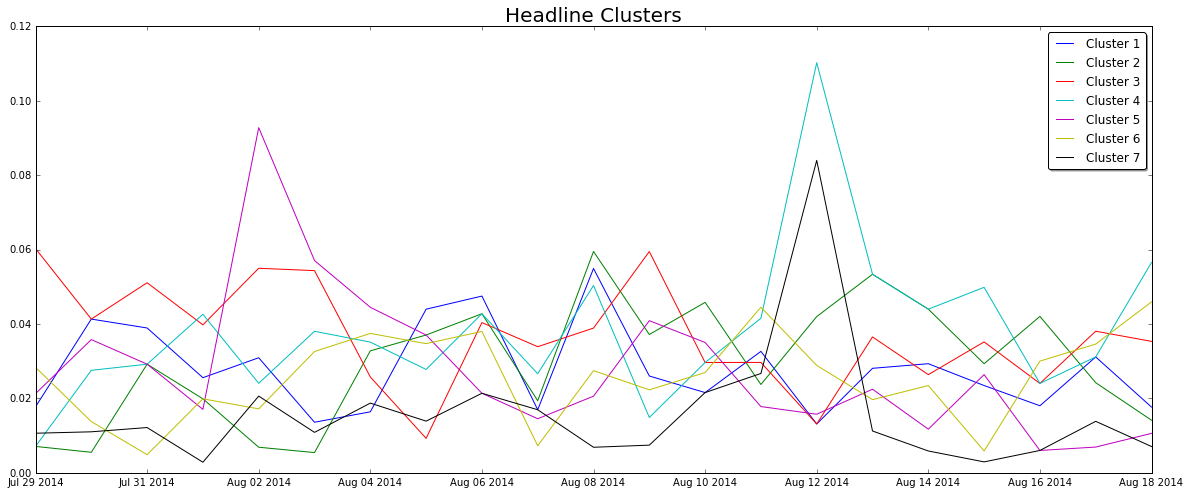

In [226]:
plot_line_graph(grouped_by_date)

In [379]:
def stacked_graph_data_smooth(df):
    X = np.array(range(len(df.index.values)))
    X_smooth = np.linspace(X.min(),X.max(),150)
    
    store = []
    for i in xrange(1,len(my_topics)+1):
        key = str(i) + ' date ratio'
        values = np.array(list(df[key].values))
        smooth = list(spline(X,values,X_smooth))
        store.append(smooth)
    
    Y_smooth = np.array(store)
    
    return X_smooth, Y_smooth


def plot_stacked_graph_smooth(df):
    plt.figure(figsize = (20, 8))
    ax = plt.subplot(111)
    plt.stackplot(stacked_graph_data_smooth(df)[0], stacked_graph_data_smooth(df)[1], baseline='wiggle')
    plt.title('Headline Clusters', fontsize = 20)
    plt.axis('tight')
    ax.legend(['Cluster ' + str(i) + ':' + cluster_dict[str(i)] for i in xrange(1,len(my_topics)+1)], loc='upper center', bbox_to_anchor=(0.5, -0.10),
              fancybox=True, shadow=True, ncol=1)
    #plt.xticks(stacked_graph_data_smooth(df)[0])
    ticks = list(range(len(df.index.values)))
    labels = [pd.to_datetime(str(temp[i])).strftime('%b %d %Y') for i in range(len(list(grouped_by_date.index.values)))]
    plt.xticks(ticks, labels, rotation = 40, size='small')
    #plt.yticks([],[])
    plt.show()

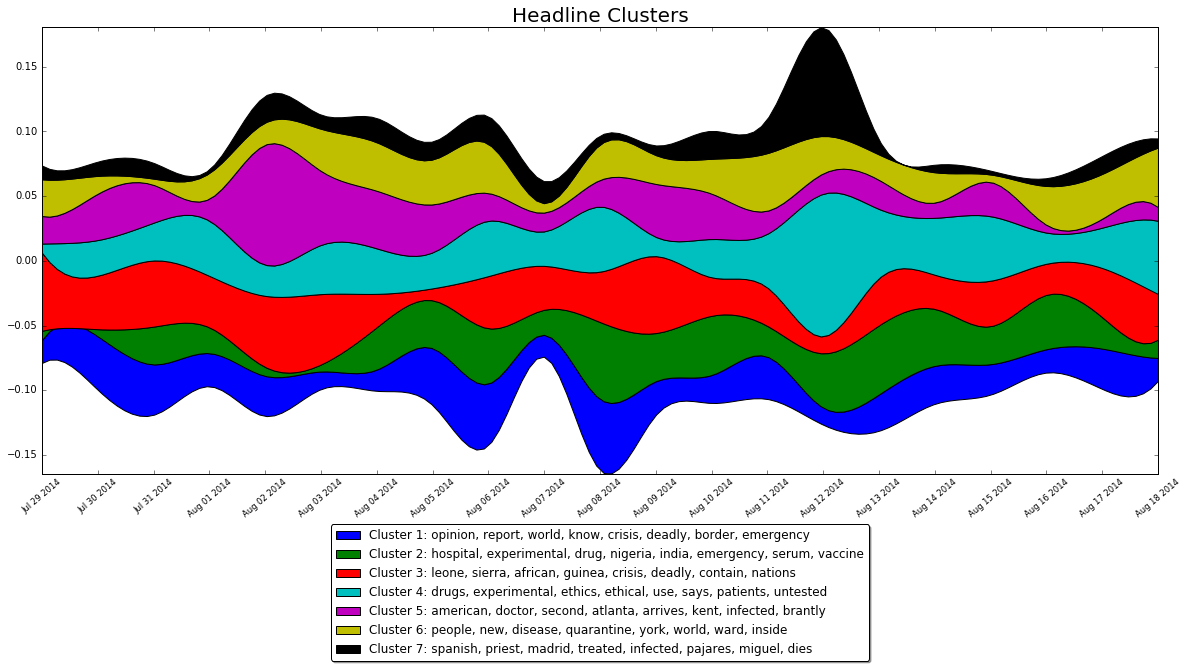

In [380]:
plot_stacked_graph_smooth(grouped_by_date)

In [368]:
def stacked_graph_data(df):
    store = []
    for i in xrange(1,len(my_topics)+1):
        key = str(i) + ' date ratio'
        values = list(df[key].values)
        store.append(values)

    Y = np.array(store)
    X = grouped_by_date.index.values
    return X, Y

def plot_stacked_graph(df):
    plt.figure(figsize = (20, 8))
    ax = plt.subplot(111)
    plt.stackplot(stacked_graph_data(df)[0], stacked_graph_data(df)[1], baseline='sym')
    plt.title('Headline Clusters', fontsize = 20)
    plt.axis('tight')
    ax.legend(['Cluster ' + str(i) + ':' + cluster_dict[str(i)] for i in xrange(1,len(my_topics)+1)], loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    plt.yticks([],[])
    plt.show()

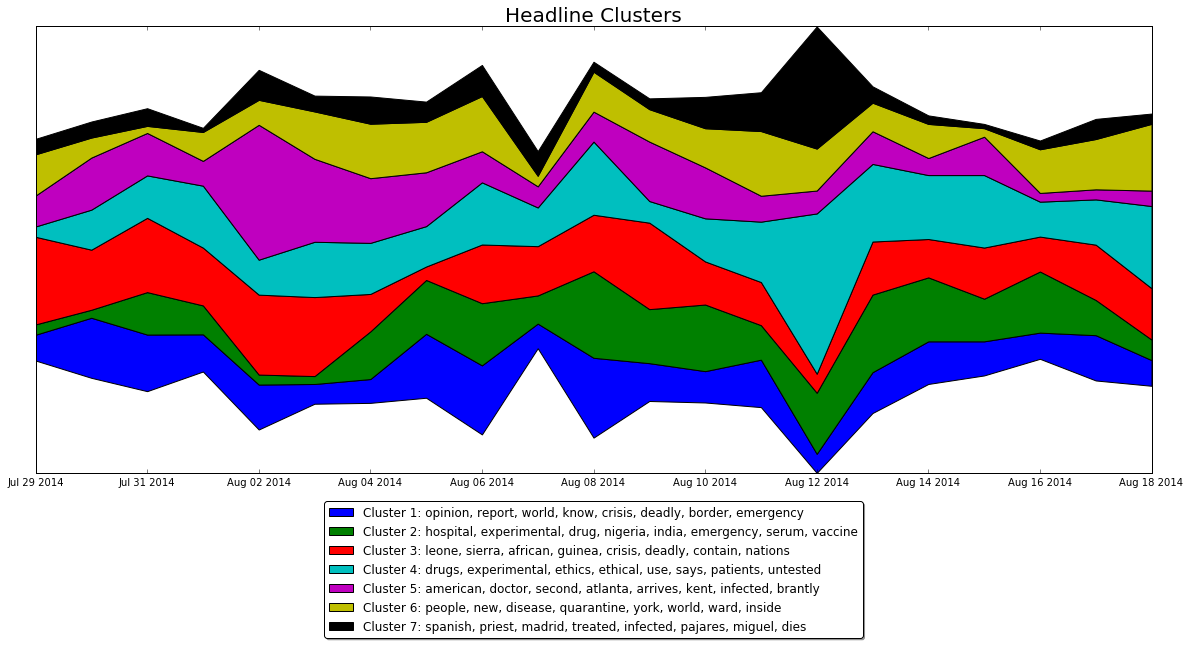

In [369]:
plot_stacked_graph(grouped_by_date)

In [86]:
# TODO: lemmatize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

def lemmat(x):
    store = []
    for i in x:
        try:
            store.append(wordnet_lemmatizer.lemmatize(i))
        except UnicodeDecodeError:
            continue
    return store    

df['headline'] = df['headline'].apply(lemmat)
df.head()